In [234]:
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import os
sns.set_theme()

In [235]:
def subj_file(subj_str: str, trial_type: str, data_type: str):
    folder = f"bloodflow_data/{subj_str}"
    filename = None
    files = None
    
    if trial_type in ['baseline', 'base', 'basline']:
        files = [file_name for file_name in os.listdir(folder) if 'baseline' in file_name or 'basline' in file_name or 'base' in file_name]

    elif trial_type in ['post-oc', 'post-occ', 'post-occlusion', 'post']:
        files = [file_name for file_name in os.listdir(folder) if 'post' in file_name]

    else:
        raise ValueError(f"{trial_type} is not an acceptable parameter for trial_type")
    
    if data_type in ['diameter', 'diam']:
        files = [file_name for file_name in files if 'diam' in file_name]
        filename = files[0][:-4]
    elif data_type in ['time', 'time_series', 'time series', 'cyclic'] :
        files = [file_name for file_name in files if 'flow' in file_name or 'doppler' in file_name]
        filename = files[0][:str.index(files[0], '_')]
        
    else:
        raise ValueError(f"{data_type} is not an acceptable parameter for data_type")
    
    return f"{folder}/{filename}"



In [236]:
def get_matlab_data(filename: str):
    matlab_data = sp.io.loadmat(f"{filename}.fig")[
        "hgS_070000"]["children"][0][0][0]["children"][0][0][0]["properties"]["YData"][0][0][0]
    
    matlab_data[matlab_data == -1] = np.NaN
    return matlab_data


In [237]:
def get_raw_data(filename: str):
    raw_data = np.load(f"{filename}.npy")
    return raw_data["diameters"]


In [238]:
def spline_interpolate_nan(array):
    nan_indices = np.isnan(array)
    valid_indices = np.arange(len(array))[~nan_indices]
    valid_values = array[~nan_indices]
    
    spline = sp.interpolate.UnivariateSpline(valid_indices, valid_values, s=0)

    # Interpolate NaN values using the fitted spline
    array[nan_indices] = spline(np.flatnonzero(nan_indices))
    return array


In [239]:
def filter_diameter(diameter_series: np.ndarray, cutoff_frame=False, apply_median_filter=False):

    # print(f"Percent NaN before filtering: {diameter_series.isna().sum() / len(diameter_series) * 100}%")
    
    diameter_array = diameter_series.copy()
    
    # Interpolate NaN values
    interpolated_diameter = spline_interpolate_nan(diameter_array.copy())
    
    # Low-pass and high-pass filter parameters
    low_pass_cutoff_frequency = 0.05
    filter_order = 2
    
    # Apply high-pass filter
    highpass_filter = sp.signal.butter(filter_order, low_pass_cutoff_frequency, 'highpass', output='sos')
    highpass_filtered = sp.signal.sosfilt(highpass_filter, interpolated_diameter)
    
    # Plot high-pass filtered data before thresholding
    
    # Calculate deviation and identify outliers
    deviation_threshold = np.std(highpass_filtered) * 0.9
    outlier_mask = (highpass_filtered > deviation_threshold) | (highpass_filtered < -deviation_threshold)
    
    # Exclude the first and last 30 samples to prevent ringing from high pass filtering
    outlier_mask[:30] = False
    outlier_mask[-30:] = False
    
    # Mark indices to be removed, including 2 indices before and after
    removal_mask = np.zeros_like(highpass_filtered, dtype=bool)
    for index in range(len(outlier_mask)):
        if outlier_mask[index]:
            start = max(0, index - 1)
            end = min(len(outlier_mask), index + 2)
            removal_mask[start:end] = True
    
    # Set outliers to NaN
    diameter_array[removal_mask] = np.NaN
    highpass_filtered[removal_mask] = np.NaN
    
    
    # Calculate median and threshold for further filtering
    median_diameter = np.nanmedian(diameter_array)
    filtering_threshold = np.nanstd(diameter_array) * 2
    extreme_outlier_mask = (diameter_array > median_diameter + filtering_threshold) | (diameter_array < median_diameter - filtering_threshold)
    
    
    # Set extreme outliers to NaN
    diameter_array[extreme_outlier_mask] = np.NaN
    
    # Convert to DataFrame
    diameter_dataframe = pd.DataFrame({"diameter": diameter_array})
    
    # print(f"Percent NaN after filtering: {diameter_dataframe.isna().sum() / len(diameter_dataframe) * 100}%")
    
    
    # Apply cutoff frame if specified
    if cutoff_frame:
        diameter_dataframe = diameter_dataframe.iloc[:cutoff_frame]
    
    # Apply median filter if specified
    if apply_median_filter:
        diameter_dataframe = diameter_dataframe.rolling(window=len(diameter_dataframe) // 50, min_periods=1).median()
    
    return diameter_dataframe


# Read in data

In [240]:
files = []
subj_nums = list(range(5,25))
subj_name = lambda num: f"ASCI{num:03}"

exclude = []
for subj_num in subj_nums:
    if subj_num not in exclude:
        files.append(subj_file(subj_name(subj_num), 'baseline', 'diam'))
        files.append(subj_file(subj_name(subj_num), 'post', 'diam'))
        
subj_nums = list(range(1,15))
subj_name = lambda num: f"ASCI1{num:02}"

exclude = []
for subj_num in subj_nums:
    if subj_num not in exclude:
        files.append(subj_file(subj_name(subj_num), 'baseline', 'diam'))
        files.append(subj_file(subj_name(subj_num), 'post', 'diam'))
        
        
files = np.array(files)
files = np.unique(files)


In [241]:
bwave_means = []
flowave_means = []

bwave_stds = []
flowave_stds = []

baseline = True

total_frames = 0
bwave_frames = []
flowave_frames = []

In [242]:
plot = False
for filename in files:
    tag = 'baseline' if baseline else 'post'

    
    diameter_data = get_raw_data(filename)
    diameter = pd.DataFrame()
    diameter['bwave'] = filter_diameter(diameter_data)
    diameter["flowave"] = get_matlab_data(filename)
    

    bwave_frames.append( len(diameter['bwave'].dropna())  / len(diameter)) 
    flowave_frames.append(len(diameter['flowave'].dropna()) / len(diameter)) 

    if plot:
        diameter.plot()

    bwave_means.append(diameter["bwave"].mean())
    flowave_means.append(diameter["flowave"].mean())

    bwave_stds.append(diameter["bwave"].std())
    flowave_stds.append(diameter["flowave"].std())
    
    lower_confidence, upper_confidence = sp.stats.norm.interval(0.95, loc = diameter['bwave'].mean(), scale = diameter['bwave'].std())
    
    if plot:
        plt.axhline(lower_confidence, color = '#4c72b0', linestyle = '--', alpha = 0.4)
        plt.axhline(upper_confidence, color = '#4c72b0', linestyle = '--', alpha = 0.4)
        
    lower_confidence, upper_confidence = sp.stats.norm.interval(0.95, loc = diameter['flowave'].mean(), scale = diameter['flowave'].std())

    if plot:
        plt.axhline(lower_confidence, color = '#dd8452', linestyle = '--', alpha = 0.4)
        plt.axhline(upper_confidence, color = '#dd8452', linestyle = '--', alpha = 0.4)
        plt.title(f"{filename[15:22]} {tag}")
        plt.xlabel("Frame #")
        plt.ylabel("Diameter (px)")


        # plt.savefig(f"bland_altman_plots/{filename[15:22]}_{tag}_diameter_comparison.png", dpi = 300)
        plt.show()
        
    baseline = not baseline

# Bland-Altman Comparison

In [243]:
bwave_means = np.array(bwave_means)
flowave_means = np.array(flowave_means)
np.nan_to_num(flowave_means, copy=False)
means = (bwave_means + flowave_means) / 2
diffs = bwave_means - flowave_means

In [244]:
bland_r, bland_p = sp.stats.pearsonr(bwave_means, flowave_means) 

In [245]:
bwave_means.mean(), np.std(bwave_means)

(44.28762265922556, 6.385546026843141)

In [246]:
flowave_means.mean(), np.std(flowave_means)

(39.86252588823815, 6.473078607539617)

In [247]:
bias = np.mean(diffs)
s = np.std(diffs, ddof=1)

upper_loa = bias + 1.96 * s
lower_loa = bias - 1.96 * s

In [248]:
props = lambda color: dict(boxstyle='round', facecolor= color, alpha=0.5, edgecolor = color)
coefficient_text = lambda label, r, p: f"$\\bf {label}$" + f"\n$R^2$ = {r:0.3f}, $p$ = {p:0.3f}"

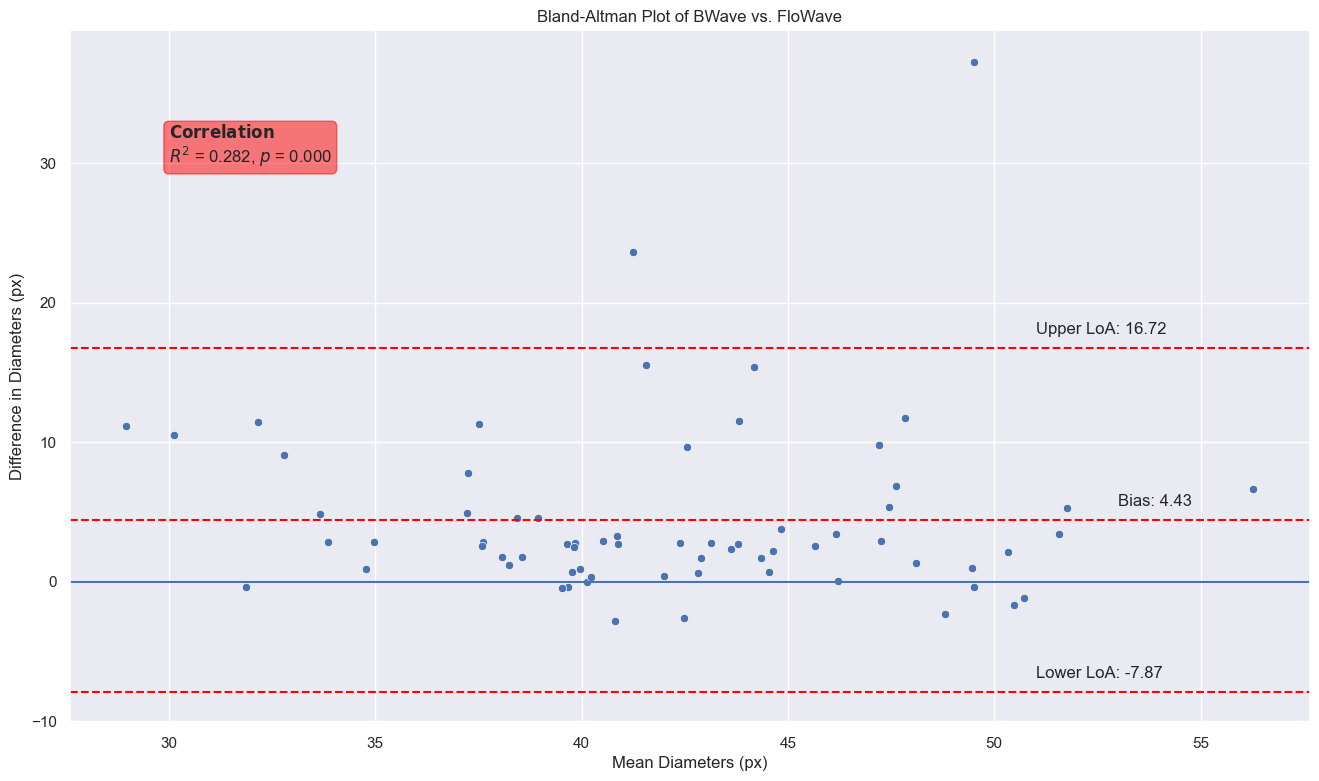

In [249]:
plt.figure(figsize= (16,9))
plt.title('Bland-Altman Plot of BWave vs. FloWave')
plt.xlabel('Mean Diameters (px)')
plt.ylabel('Difference in Diameters (px)')
plt.annotate("Correlatin", xy = (10,50))
plt.axhline(upper_loa, color='red', linestyle='--')
plt.axhline(lower_loa, color='red', linestyle='--')
plt.axhline(bias, color='red', linestyle='--')
plt.axhline(0)

plt.annotate(coefficient_text("Correlation", bland_r**2, bland_p), xy = (30, 30), bbox = props('red'))
plt.annotate(f"Upper LoA: {upper_loa:0.2f}", xy = (51, upper_loa+1))
plt.annotate(f"Lower LoA: {lower_loa:0.2f}", xy = (51, lower_loa+1))
plt.annotate(f"Bias: {bias:0.2f}", xy = (53, bias+1))

sns.scatterplot(x=means, y=diffs)
plt.show()

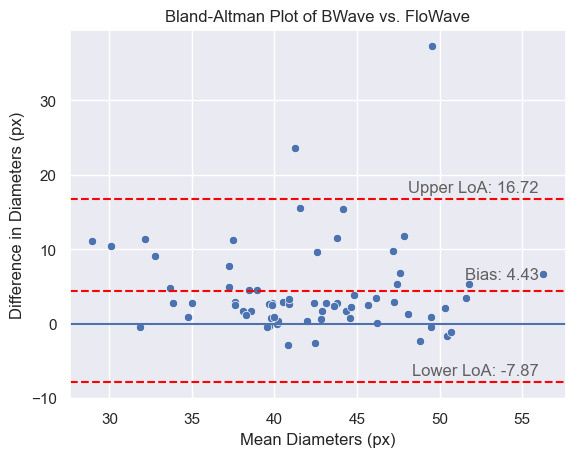

In [250]:
plt.title('Bland-Altman Plot of BWave vs. FloWave')
plt.xlabel('Mean Diameters (px)')
plt.ylabel('Difference in Diameters (px)')
plt.axhline(upper_loa, color='red', linestyle='--')
plt.axhline(lower_loa, color='red', linestyle='--')
plt.axhline(bias, color='red', linestyle='--')
plt.axhline(0)

plt.annotate(f"Upper LoA: {upper_loa:0.2f}", xy = (56, upper_loa+1), alpha = 0.7, ha = 'right')
plt.annotate(f"Lower LoA: {lower_loa:0.2f}", xy = (56, lower_loa+1), alpha = 0.7, ha = 'right')
plt.annotate(f"Bias: {bias:0.2f}", xy = (56, bias+1.5), alpha = 0.7, ha = 'right')
sns.scatterplot(x=means, y=diffs)
plt.show()

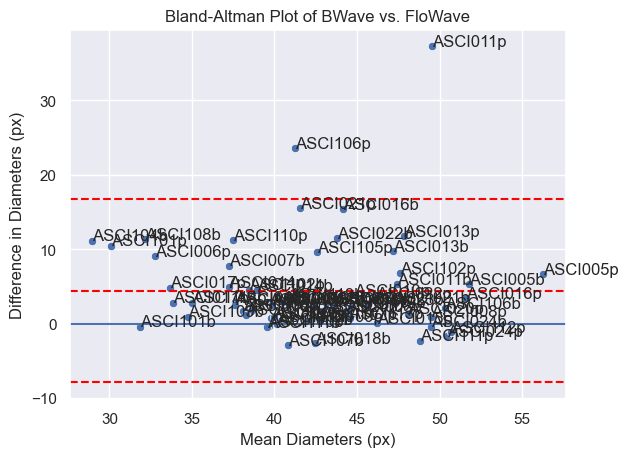

In [251]:
sns.set_context('notebook')
plt.title('Bland-Altman Plot of BWave vs. FloWave')
plt.xlabel('Mean Diameters (px)')
plt.ylabel('Difference in Diameters (px)')
plt.axhline(upper_loa, color='red', linestyle='--')
plt.axhline(lower_loa, color='red', linestyle='--')
plt.axhline(bias, color='red', linestyle='--')
plt.axhline(0)
sns.scatterplot(x=means, y=diffs)

for i, filename in enumerate(files):
    tag = 'b' if i%2==0 else 'p'
    
    plt.annotate(f"{filename[15:22]}{tag}", (means[i], diffs[i]))

# plt.savefig("bland_altman_plots/bishoy_flowave_bland_altman.png")
plt.show()

# Frame Drop Comparison

In [252]:
data = pd.DataFrame({
    'value': bwave_frames + flowave_frames,
    'method': ['bwave'] * len(bwave_frames) + ['flowave'] * len(flowave_frames)
})

In [253]:
data['trial'] = ['baseline', 'post'] * (len(data)//2)
data

,value,method,trial
0,0.877976,bwave,baseline
1,0.745674,bwave,post
2,0.844111,bwave,baseline
3,0.769864,bwave,post
4,0.418398,bwave,baseline
...,...,...,...
131,0.923511,flowave,post
132,1.000000,flowave,baseline
133,1.000000,flowave,post
134,0.994550,flowave,baseline


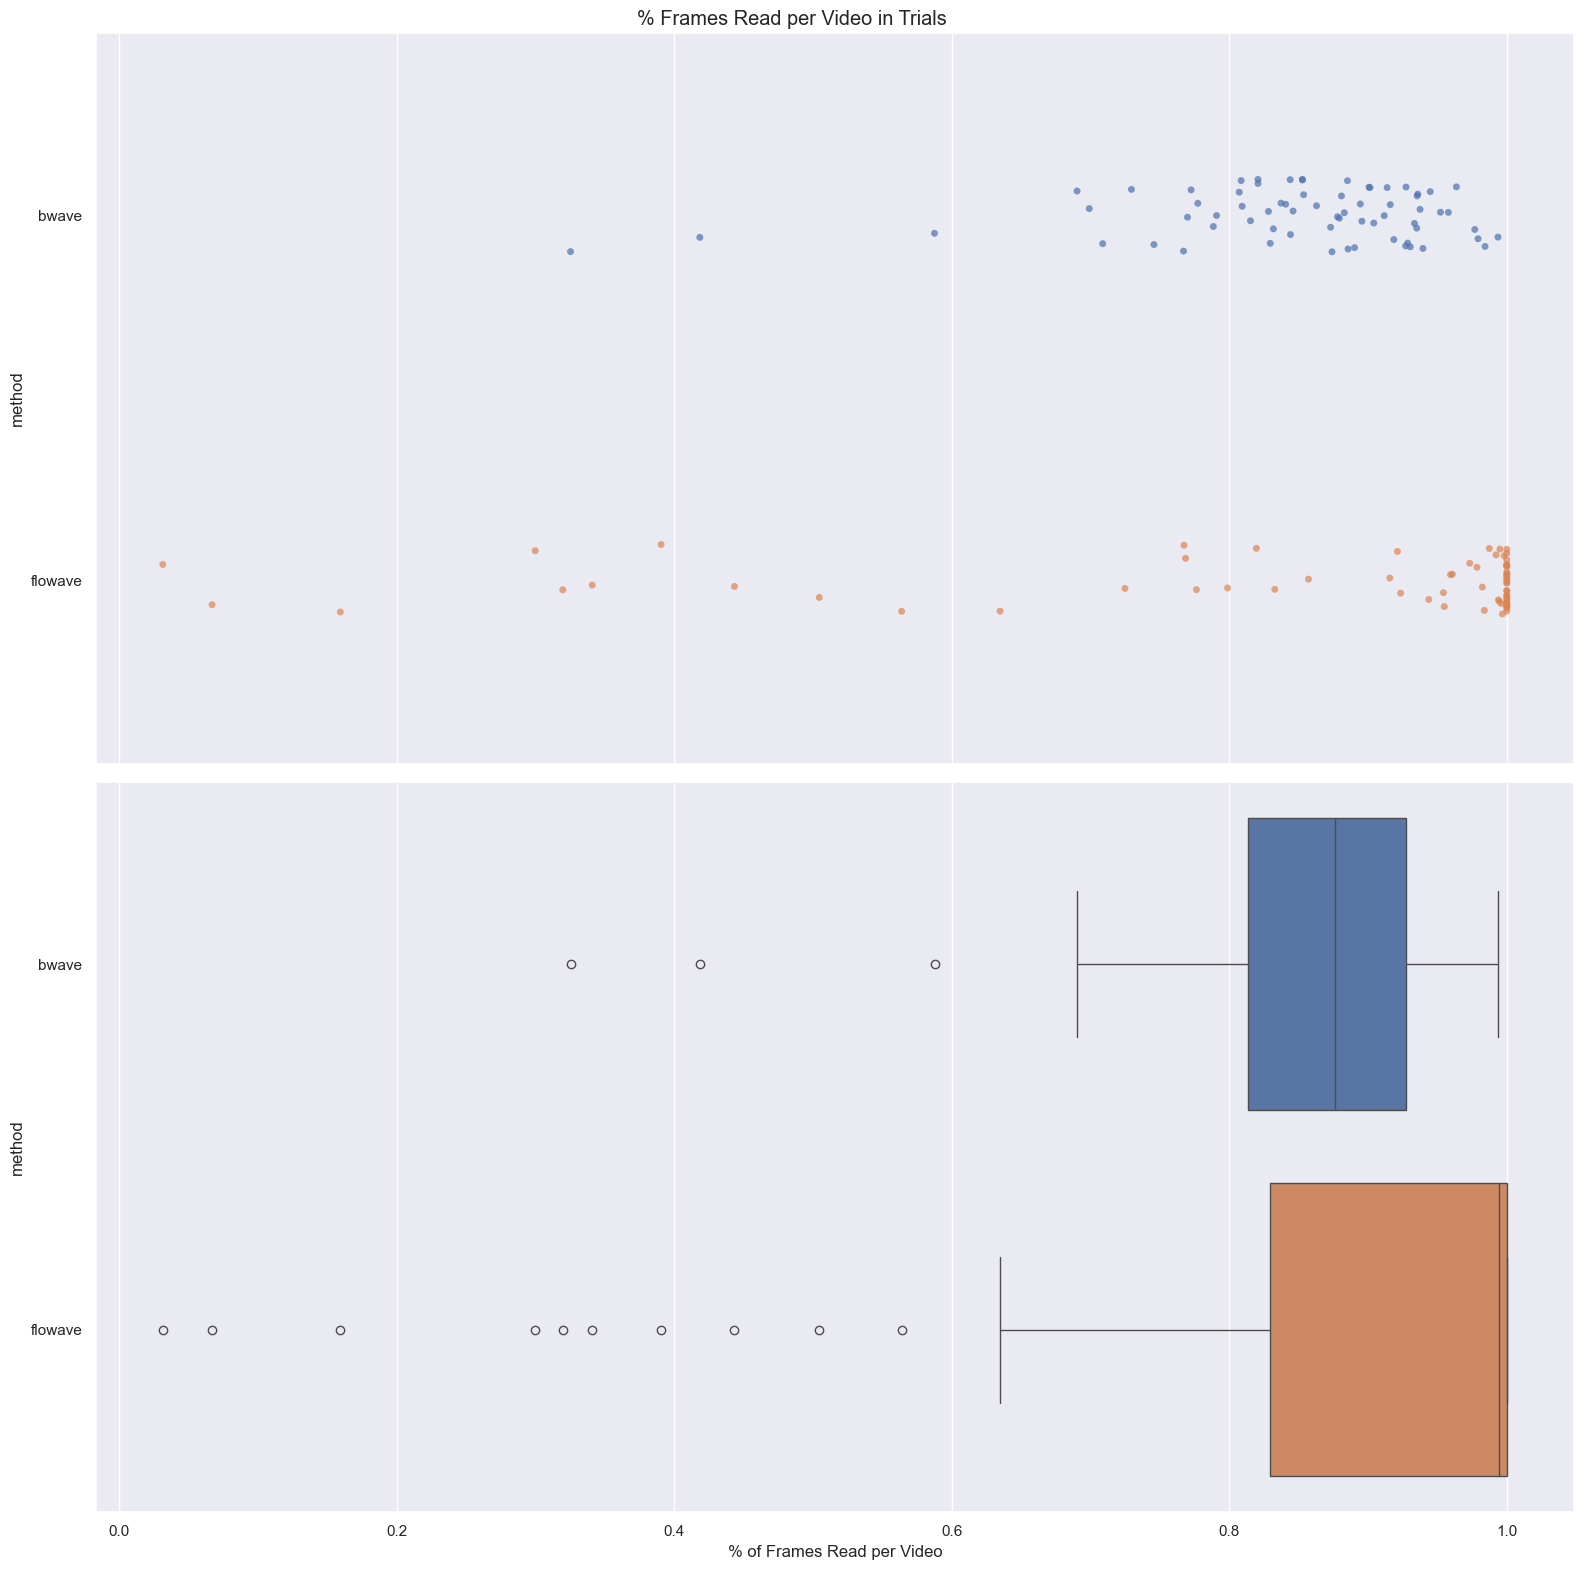

In [254]:
fig, ax = plt.subplots(2,1, sharey=True, sharex = True, figsize = (16,16))
sns.stripplot(y='method', x='value', data=data, hue = 'method', ax = ax[0], alpha = 0.7)
plt.xlabel("% of Frames Read per Video")
sns.boxplot(y='method', x='value', data=data, hue = 'method', ax = ax[1], fill = True)
plt.xlabel("% of Frames Read per Video")
plt.suptitle("% Frames Read per Video in Trials")
plt.tight_layout()
plt.show()

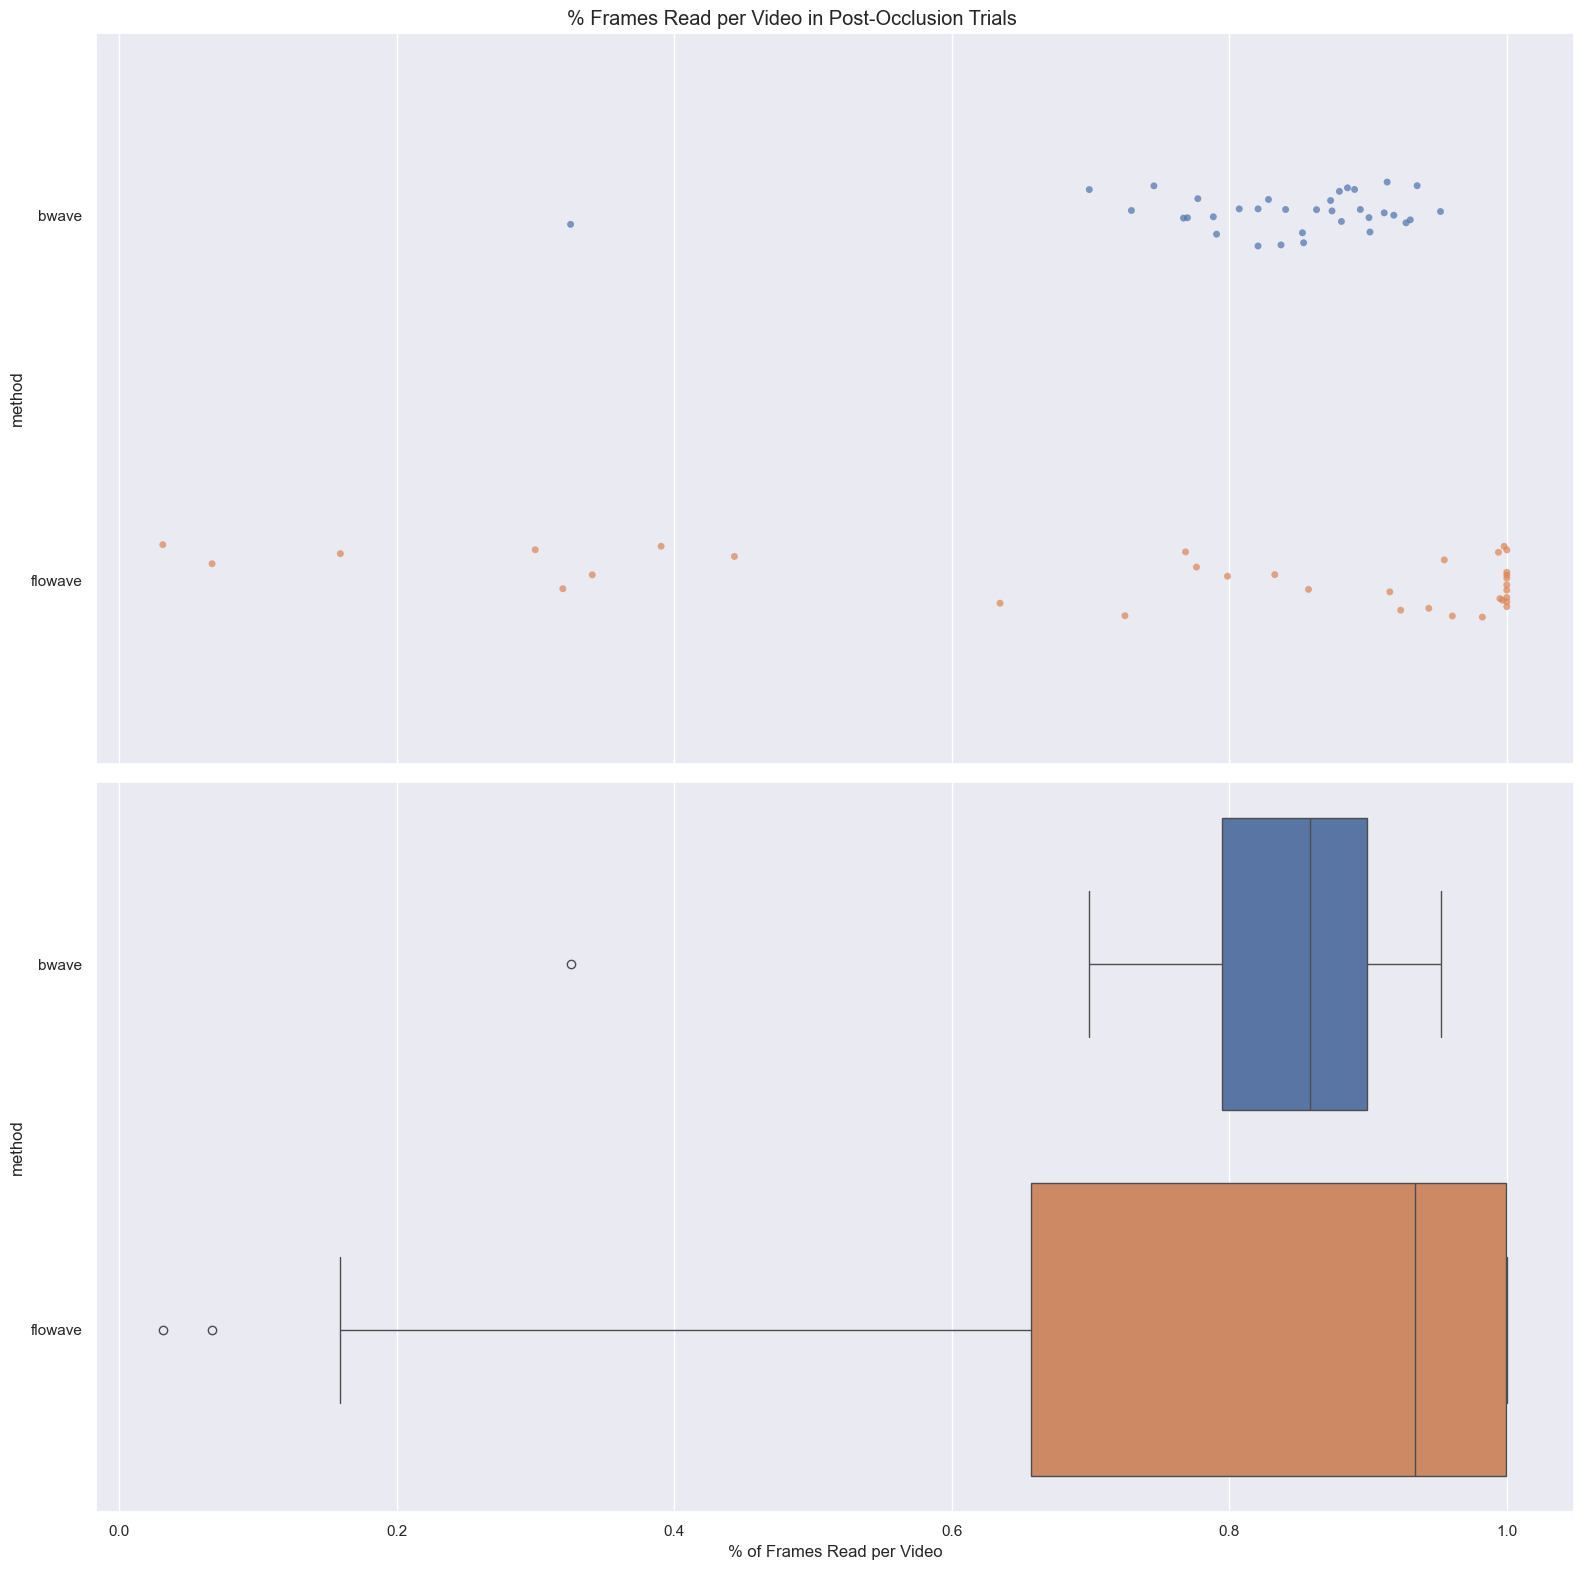

In [255]:
fig, ax = plt.subplots(2,1, sharey=True, sharex = True, figsize = (16,16))
sns.stripplot(y='method', x='value', data=data[data['trial'] == 'post'], hue = 'method', alpha = 0.7, ax = ax[0])
plt.xlabel("% of Frames Read per Video")
sns.boxplot(y='method', x='value', data=data[data['trial'] == 'post'], hue = 'method', fill = True, ax = ax[1])
plt.xlabel("% of Frames Read per Video")
plt.suptitle("% Frames Read per Video in Post-Occlusion Trials")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, '% Frames Read per Video in Baseline Trials')

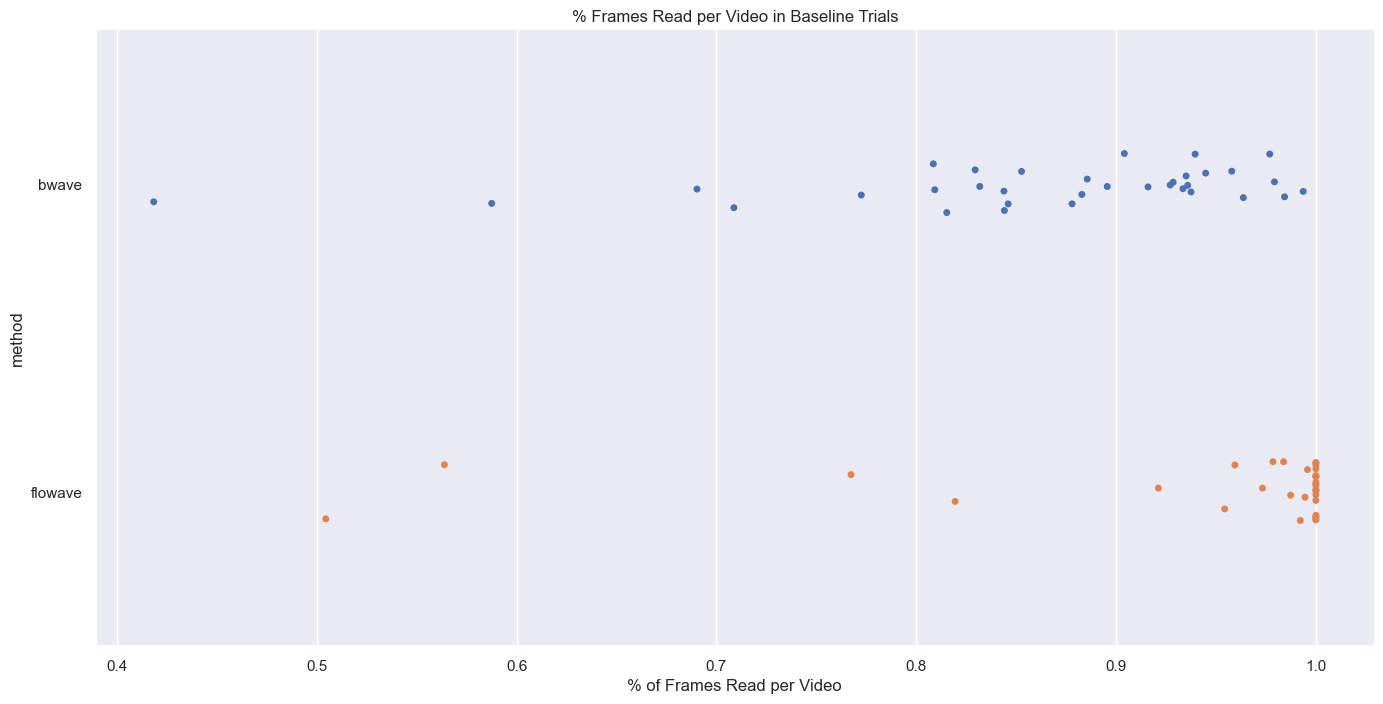

In [256]:
sns.catplot(y='method', x='value', data=data[data['trial']== 'baseline'], hue = 'method', height=7, aspect=2)
plt.xlabel("% of Frames Read per Video")
plt.title("% Frames Read per Video in Baseline Trials")

In [257]:
data

,value,method,trial
0,0.877976,bwave,baseline
1,0.745674,bwave,post
2,0.844111,bwave,baseline
3,0.769864,bwave,post
4,0.418398,bwave,baseline
...,...,...,...
131,0.923511,flowave,post
132,1.000000,flowave,baseline
133,1.000000,flowave,post
134,0.994550,flowave,baseline


Text(0.5, 0, '% of Frames Read')

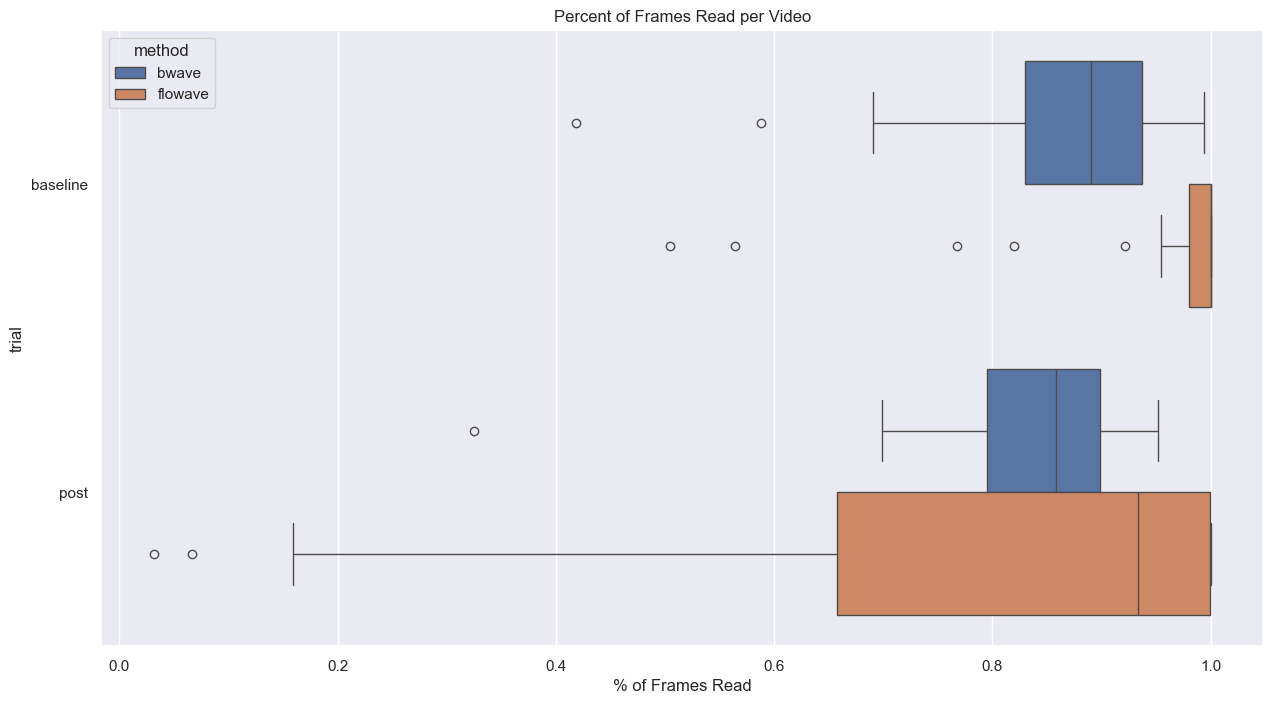

In [258]:
plt.figure(figsize=(15,8))
sns.boxplot(data = data, x = 'value', y = 'trial', hue = 'method')
plt.title('Percent of Frames Read per Video')
plt.xlabel('% of Frames Read')

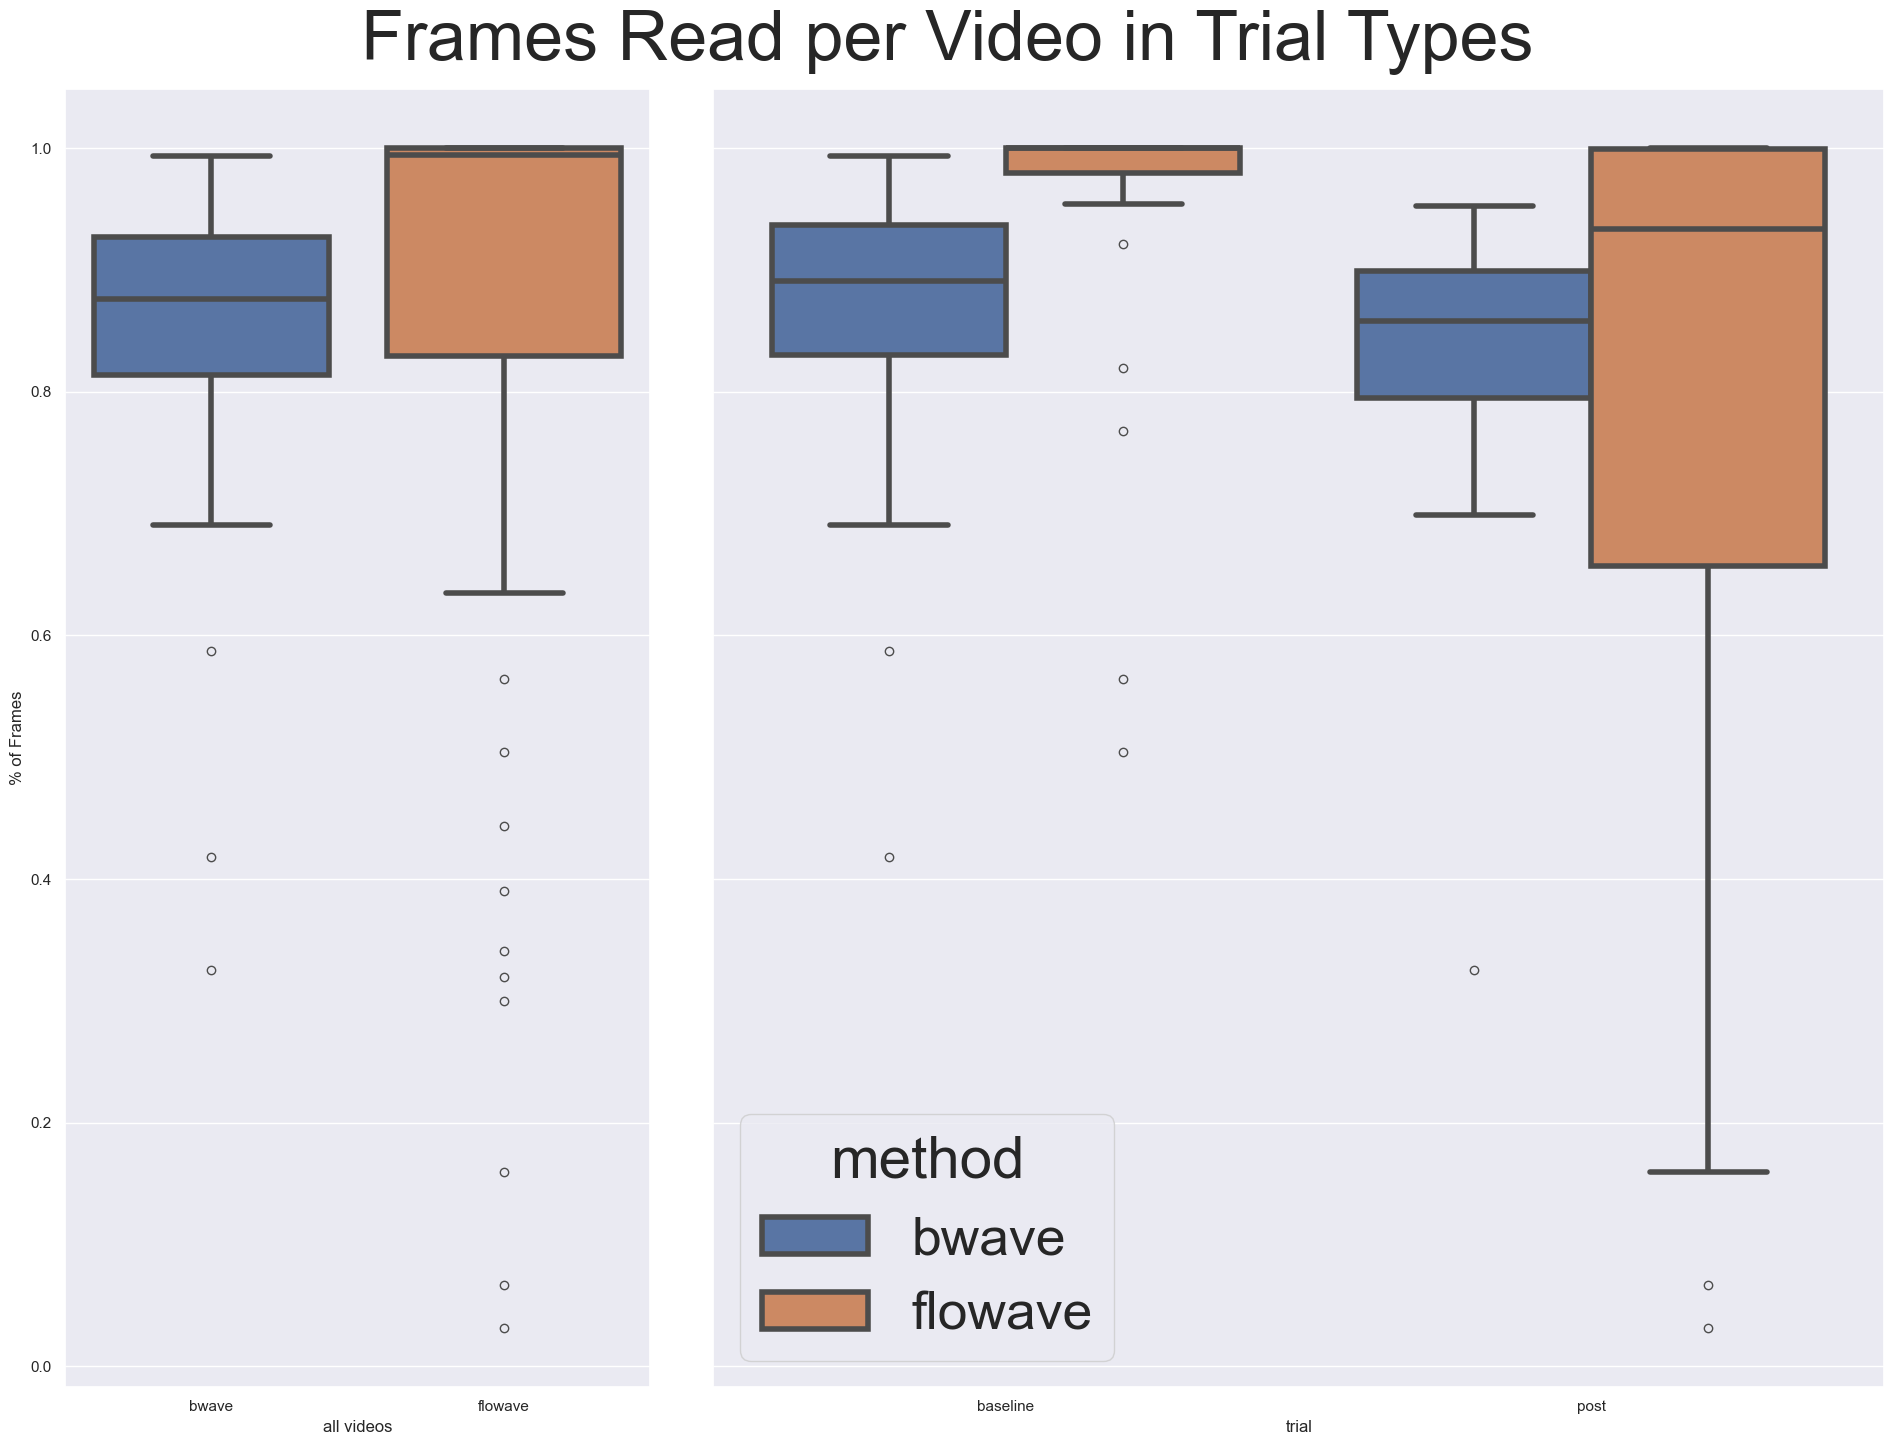

In [259]:
fig, ax = plt.subplots(1,2 , figsize=(20,16), width_ratios=[1, 2], sharey = True)
sns.set(font_scale=3.5)
sns.boxplot(y='value', x='trial', data=data, hue = 'method', ax = ax[1], fill = True, linewidth=4)
sns.boxplot(data = data, y = 'value', x = 'method', hue = 'method', ax = ax[0], fill = True, linewidth=4)
ax[0].set_xlabel("all videos")
ax[0].set_ylabel("% of Frames")
plt.suptitle("Frames Read per Video in Trial Types", y = 0.93)
plt.tight_layout()
plt.show()
sns.set(context='notebook', font_scale=1)

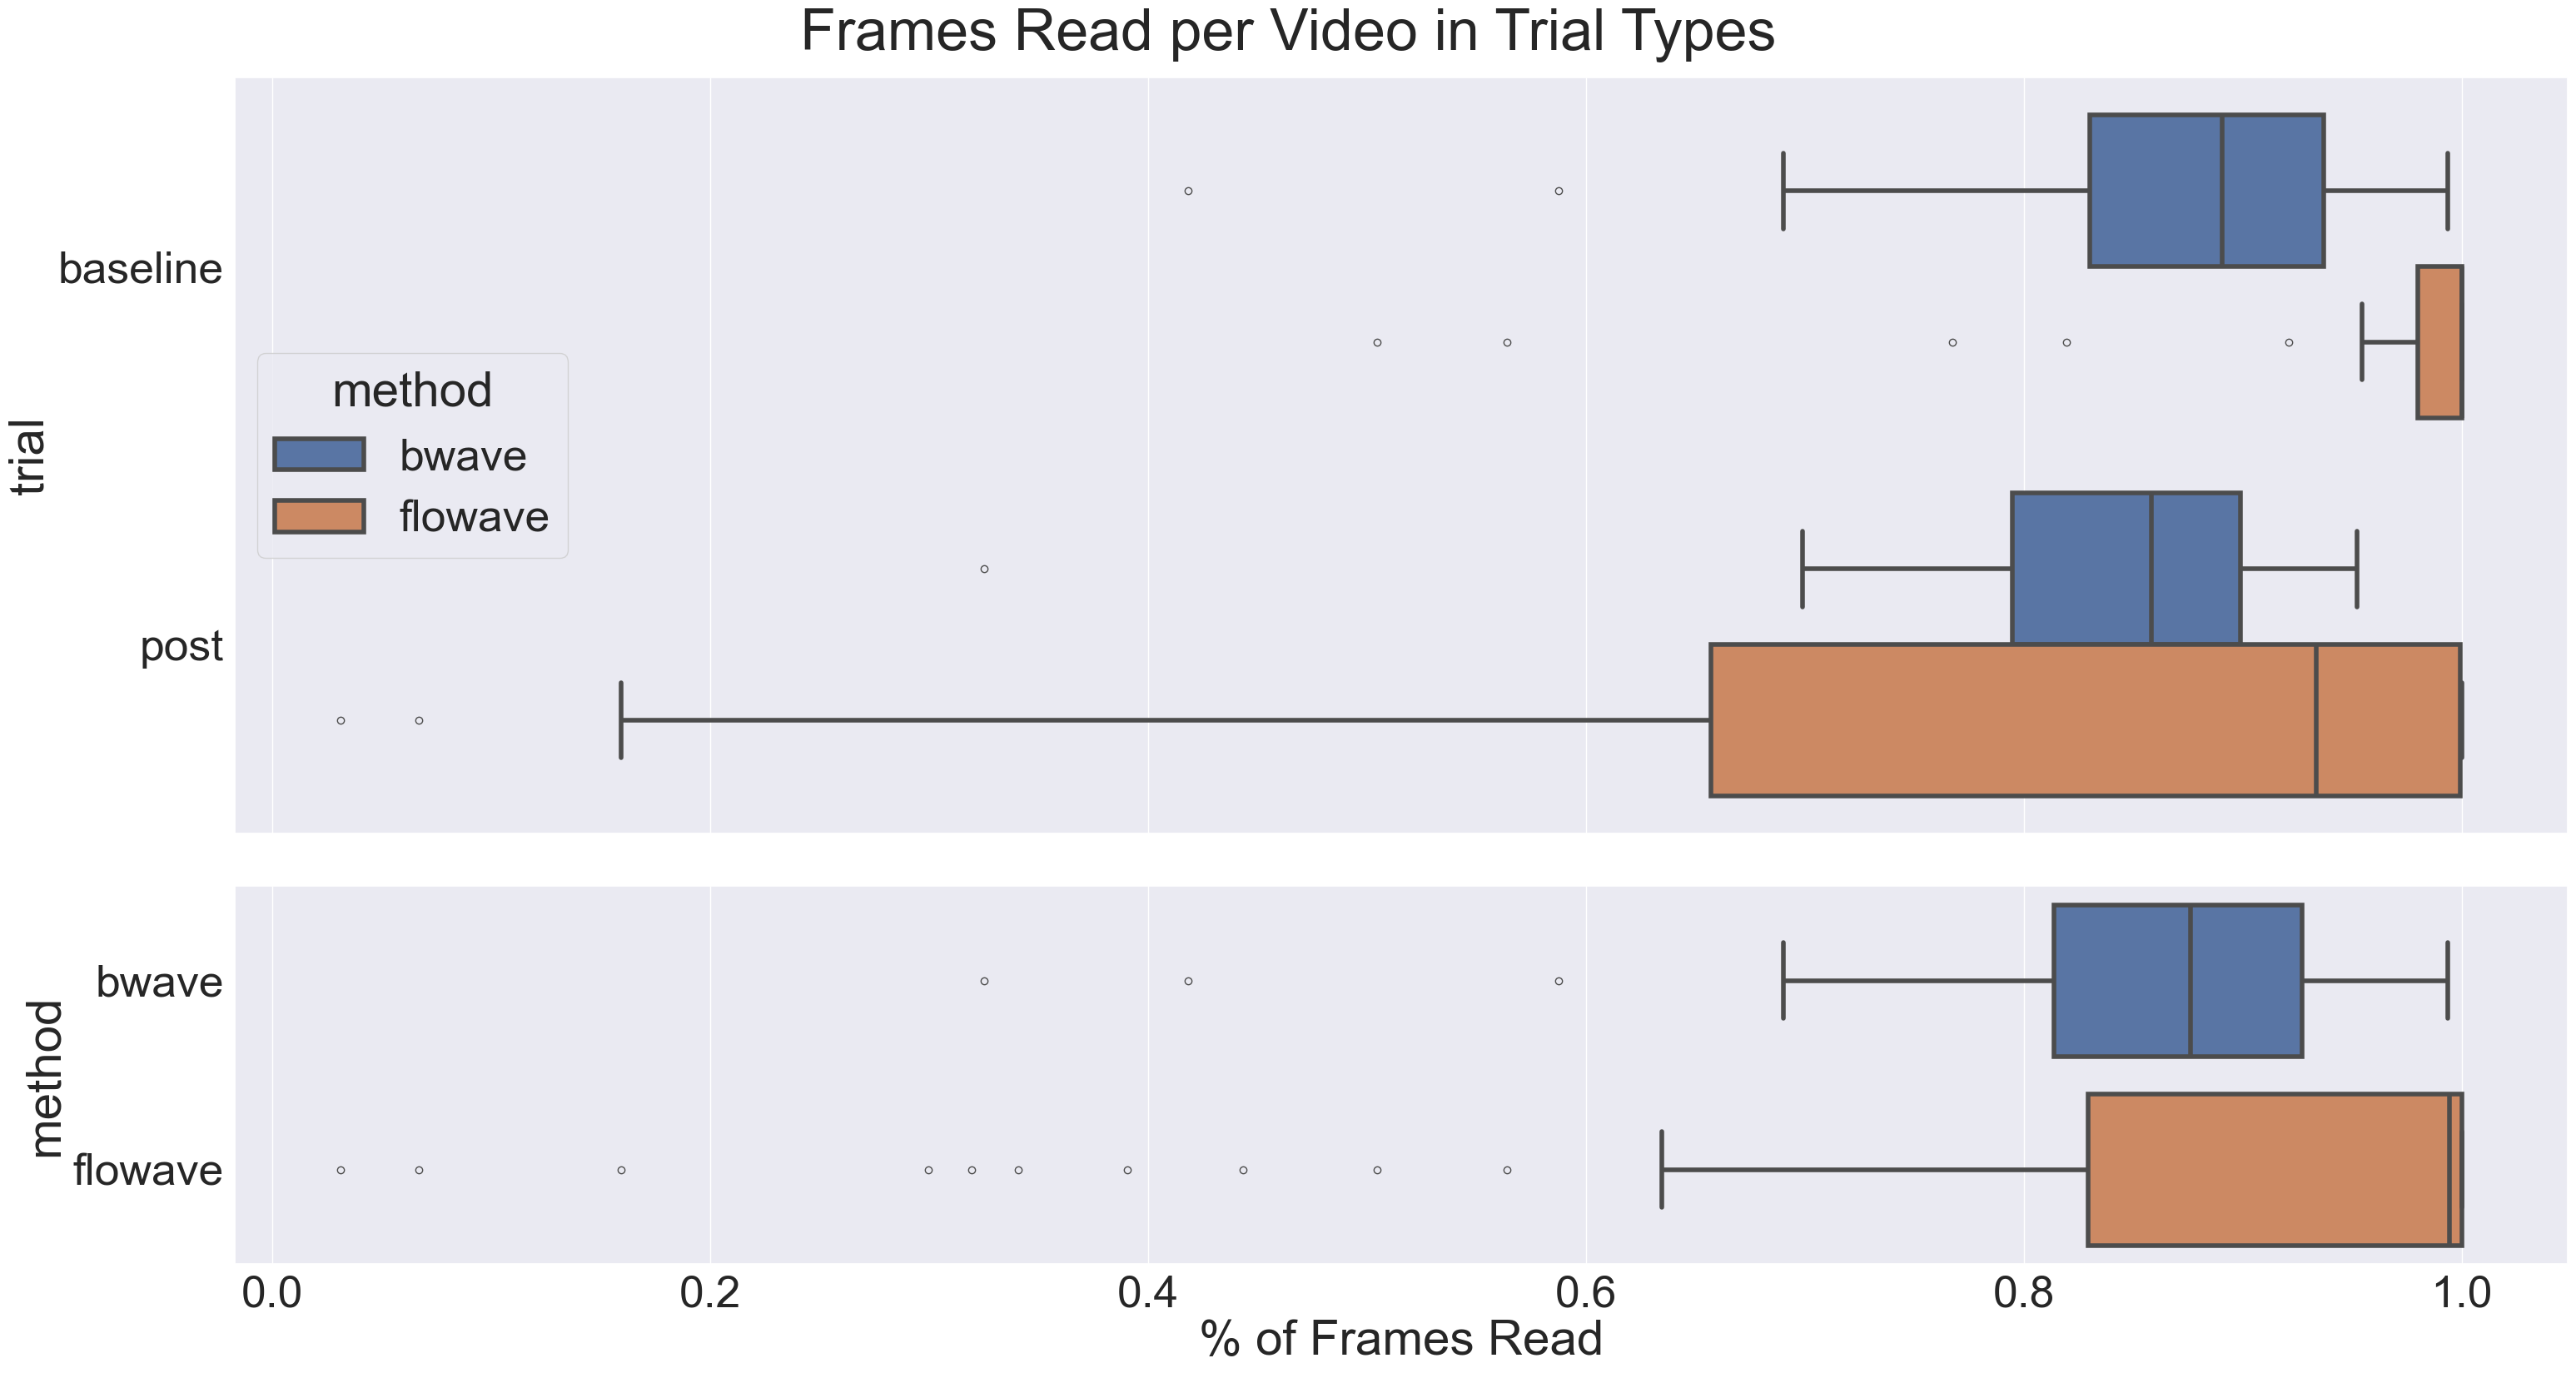

In [260]:
sns.set(font_scale=3.5)
fig, ax = plt.subplots(2,1 , figsize=(32,18), height_ratios= [2,1], sharex = True)
sns.boxplot(data = data, x = 'value', y = 'trial', hue = 'method', ax = ax[0], fill = True, linewidth=4)
sns.boxplot(data = data, x = 'value', y = 'method',  hue = 'method', ax = ax[1], fill = True, linewidth=4)
plt.suptitle("Frames Read per Video in Trial Types", y = 0.94)
plt.xlabel('% of Frames Read')
plt.tight_layout()
plt.show()
sns.set(font_scale=1)

# Wilcoxon

In [261]:
flowave = data[data['method'] == 'flowave']
flowave.reset_index(inplace = True, drop = True)
bwave = data[data['method'] == 'bwave']
frame_data = pd.DataFrame()
frame_data['trial'] = bwave['trial']
frame_data['bwave'] = bwave['value']
frame_data['flowave'] = flowave['value']
frame_data

,trial,bwave,flowave
0,baseline,0.877976,1.000000
1,post,0.745674,0.996854
2,baseline,0.844111,0.983834
3,post,0.769864,0.915698
4,baseline,0.418398,0.973294
...,...,...,...
63,post,0.890282,0.923511
64,baseline,0.944837,1.000000
65,post,0.880814,1.000000
66,baseline,0.809264,0.994550


In [262]:
sp.stats.wilcoxon(frame_data['bwave'], frame_data['flowave'])

WilcoxonResult(statistic=787.0, pvalue=0.0183441921960548)

In [263]:
sp.stats.wilcoxon(frame_data[frame_data['trial'] == 'baseline']['bwave'], frame_data[frame_data['trial'] == 'baseline']['flowave'])

WilcoxonResult(statistic=84.0, pvalue=0.00011595466639846563)

In [264]:
sp.stats.wilcoxon(frame_data[frame_data['trial'] == 'post']['bwave'], frame_data[frame_data['trial'] == 'post']['flowave'], alternative= 'less')

WilcoxonResult(statistic=305.0, pvalue=0.553689559281338)

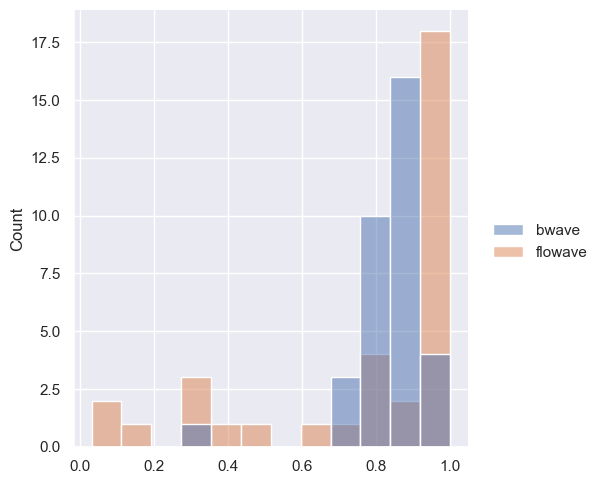

In [265]:
sns.displot(frame_data[frame_data['trial'] == 'post'])

In [266]:
sp.stats.normaltest(bwave[bwave['trial'] == 'post']['value'])

NormaltestResult(statistic=47.27765687964448, pvalue=5.417354426600826e-11)

In [267]:
describe = lambda s: print(f"Median {s.quantile(0.5):.3f}, 0.25: {s.quantile(0.25):.3f}, 0.75: {s.quantile(0.75):.3f}, IQR: {s.quantile(0.75) - s.quantile(0.25):.3f}")

overall iqr

In [268]:
describe(bwave['value'])

Median 0.876, 0.25: 0.814, 0.75: 0.927, IQR: 0.113


In [269]:
describe(flowave['value'])

Median 0.994, 0.25: 0.829, 0.75: 1.000, IQR: 0.171


post-occlusion iqr

In [270]:
describe(bwave[bwave['trial'] == 'post']['value'])

Median 0.858, 0.25: 0.795, 0.75: 0.899, IQR: 0.104


In [271]:
describe(flowave[flowave['trial'] == 'post']['value'])

Median 0.934, 0.25: 0.657, 0.75: 1.000, IQR: 0.342


baseline iqr

In [272]:
describe(bwave[bwave['trial'] == 'baseline']['value'])

Median 0.891, 0.25: 0.830, 0.75: 0.937, IQR: 0.107


In [273]:
describe(flowave[flowave['trial'] == 'baseline']['value'])

Median 1.000, 0.25: 0.980, 0.75: 1.000, IQR: 0.020
